In [1]:
using Plots, Random, Roots, FFTW, LaTeXStrings, DynamicalSystems, StatsBase

import PyPlot;
const plt = PyPlot;

#cd(dirname(@__FILE__));

# parameters
# physical cavity photon lifetime (and norm time)
tphys = 7.0 * 10^(-12);

# QW parameters
tg = 0.1 * 10^(-9);

# QD parameters
tρ = 0.1 * 10^(-9);
tn = 0.1 * 10^(-9);

delayphys = 0.7 * 10^(-9);

# normalized material parameters
# QW
etag = tphys / tg;

# QD
g = 1.15;
B = 924;
etaρ = tphys / tρ;
etan = tphys / tn;

α = 2;

# pump
JthrQW = 1;
JthrQD = ((1 + g) * (-B + g + B * g)) / (B * (-1 + g) * g);
nJthr = 1.5;
JQW = JthrQW * nJthr;
JQD = JthrQD * nJthr;

# optical feedback
τdelay = delayphys / tphys;
γ = 0.00;
ϕ = 0;
ϕs = [0, 0, 0];

# neighbor coupling
κ = 0.12;

# vectors of parameters
p0QW = [JQW, etag, α, γ, ϕ, ϕs[1], ϕs[2], ϕs[2], κ, τdelay];
p0QD = [JQD, g, B, etaρ, etan, α, γ, ϕ, ϕs[1], ϕs[2], ϕs[2], κ, τdelay];

p0QD4 = [JQD, g, B, etaρ, etan, α, γ, ϕ, ϕs[1], ϕs[2], ϕs[2], ϕs[2], κ, τdelay];

t0 = 0;

# integration procedure parameters
dt = τdelay / 10000;
hist_len = floor(Int, τdelay / dt);
endtime = 400 * τdelay;
num_iter = floor(Int, endtime / dt);
n_lasers = 4
dimQW = n_lasers * 3; # problem dimension QW
dimQD = n_lasers * 4; # problem dimension QD
savnum = 500; # number of points per delay to save
modstep = floor(Int, hist_len / savnum);


Reind = zeros(Int,n_lasers)
Imind = zeros(Int,n_lasers)

# switch QW and QD
isQW = false;
if isQW
    p0 = copy(p0QW)
    dim = dimQW
    tauind = 10
    #Reind = [1,4,7]
    #Imind = [2,5,8]
    for i = 1:n_lasers
        Reind[i] = (i - 1)*3 + 1
        Imind[i] = (i - 1)*3 + 2
    end
else
    if n_lasers == 3
        p0 = copy(p0QD)
        tauind = 13
    else
        p0 = copy(p0QD4)
        tauind = 14
    end
    dim = dimQD
    #Reind = [1,5,9]
    #Imind = [2,6,10]
    
    for i = 1:n_lasers
        Reind[i] = (i - 1)*4 + 1
        Imind[i] = (i - 1)*4 + 2
    end
end

In [3]:
k12 = 1.0
k13 = 1.0
k14 = 1.0
k23 = 1.0
k24 = 1.0
k34 = 1.0

num_iter

4000000

In [4]:
## function evaluating the derivatives for the iteration with the noise terms
# QW problem
# u is the dependent variables vector for three lasers
# indices u[1:4] are for ℜ, ℑ, ρ, n for the first laser
# u[5:8] for the second
# u[9:12] for the third
# uT is the corresponding delayed dependent variables vector
# p is the parameter vector
# p[1] - J
# p[2] - etag
# p[3] - α
# p[4] - γ
# p[5] - ϕ
# p[6] - ϕs[1]
# p[7] - ϕs[2]
# p[8] - ϕs[2]
# p[9] - κ
# p[10] - τdelay

function QW(u, E1, E2, ET1, ET2, ET3, p, nt)
    dF =
        0.5 * (1 - im * p[3]) * (u[3] - 1) * (u[1] + im * u[2]) +
        im *
        p[4] *
        exp(-im * p[5]) *
        (exp(-im * p[6]) * ET1 + exp(-im * p[7]) * ET2 + exp(-im * p[8]) * ET3) +
        im * p[9] * (E1 + E2)

    dn = p[2] * (p[1] - u[3] * (1 + u[1]^2 + u[2]^2))

    return [real(dF), imag(dF), dn]
end

function CoupledQW(u, uT, p, nt, t, t0)
    du1 = QW(
        u[1:3],
        u[4] + im * u[5],
        u[7] + im * u[8],
        uT[1] + im * uT[2],
        uT[4] + im * uT[5],
        uT[7] + im * uT[8],
        p,
        nt,
    )

    du2 = QW(
        u[4:6],
        u[1] + im * u[2],
        u[7] + im * u[8],
        uT[1] + im * uT[2],
        uT[4] + im * uT[5],
        uT[7] + im * uT[8],
        p,
        nt,
    )

    du3 = QW(
        u[7:9],
        u[1] + im * u[2],
        u[4] + im * u[5],
        uT[1] + im * uT[2],
        uT[4] + im * uT[5],
        uT[7] + im * uT[8],
        p,
        nt,
    )

    return collect(Iterators.flatten([du1, du2, du3]))
end

CoupledQW (generic function with 1 method)

In [5]:
# QD problem
# u is the dependent variables vector for three lasers
# indices u[1:4] are for ℜ, ℑ, ρ, n for the first laser
# u[5:8] for the second
# u[9:12] for the third
# uT is the corresponding delayed dependent variables vector
# p is the parameter vector
# p[1] - J
# p[2] - g
# p[3] - B
# p[4] - etaρ
# p[5] - etan
# p[6] - α
# p[7] - γ
# p[8] - ϕ
# p[9] - ϕs[1]
# p[10] - ϕs[2]
# p[11] - ϕs[2]
# p[12] - κ
# p[13] - τdelay

function FU(ρ, n, B)
    return B * n * (1 - ρ)
end

function QD(u, E1, E2, ET1, ET2, ET3, p, nt)
    dF =
        0.5 * ((1 - im * p[6]) * (p[2] * (2 * u[3] - 1) - 1)) * (u[1] + im * u[2]) +
        im *
        p[7] *
        exp(-im * p[8]) *
        (exp(-im * p[9]) * ET1 + exp(-im * p[10]) * ET2 + exp(-im * p[11]) * ET3) +
        im * p[12] * (E1 + E2)

    dρ = p[4] * (FU(u[3], u[4], p[3]) - u[3] - (2 * u[3] - 1) * (u[1]^2 + u[2]^2))

    dn = p[5] * (p[1] - u[4] - 2 * FU(u[3], u[4], p[3]))

    return [real(dF), imag(dF), dρ, dn]
end

du = [ [0.0,0.0,0.0,0.0] for i = 1:3  ]
#
function CoupledQD(u, uT, p, nt, t, t0)
    
    du1 = QD(
        u[1:4],
        u[5] + im * u[6],
        u[9] + im * u[10],
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        p,
        nt,
    )

    du2 = QD(
        u[5:8],
        u[1] + im * u[2],
        u[9] + im * u[10],
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        p,
        nt,
    )

    du3 = QD(
        u[9:12],
        u[1] + im * u[2],
        u[5] + im * u[6],
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        p,
        nt,
    )
    
    return collect(Iterators.flatten([du1, du2, du3]))
    """

    uti1 = [5,1,1]
    uti2 = [9,9,5]


    for i = 1:3
        du[i] = QD(
            u[((i - 1)*4 + 1): ((i - 1)*4 + 4)],
            u[uti1[i]] + im * u[uti1[i] + 1],
            u[uti2[i]] + im * u[uti2[i] + 1],
            uT[1] + im * uT[2],
            uT[5] + im * uT[6],
            uT[9] + im * uT[10],
            p,
            nt,
        )
    end
    return collect(Iterators.flatten(du))"""
end

CoupledQD (generic function with 1 method)

In [31]:
function QD4(u, E1, E2, E3, ET1, ET2, ET3, ET4, p, nt)
    dF =
        0.5 *
        ((1 - im * p[6]) * (p[2] * (2 * u[3] - 1) - 1)) *
        (u[1] + im * u[2]) +
        im *
        p[7] *
        exp(-im * p[8]) *
        (
            exp(-im * p[9]) * ET1 +
            exp(-im * p[10]) * ET2 +
            exp(-im * p[11]) * ET3 +
            exp(-im * p[12]) * ET4
        ) +
        im * p[13] * (E1 + E2 + E3)

    dρ =
        p[4] *
        (FU(u[3], u[4], p[3]) - u[3] - (2 * u[3] - 1) * (u[1]^2 + u[2]^2))

    dn = p[5] * (p[1] - u[4] - 2 * FU(u[3], u[4], p[3]))

    return [real(dF), imag(dF), dρ, dn]
end


function CoupledQD4(u, uT, p, nt, t, t0)

    du = [[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0]]

    du[1] = QD4(
        u[1:4],
        (u[5] + im * u[6]) * k12,
        (u[9] + im * u[10]) * k13,
        (u[13] + im * u[14]) * k14,
        
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        uT[13] + im * uT[14],
        p,
        nt,
    )
    du[2] = QD4(
        u[5:8],
        (u[1] + im * u[2]) * k12,
        (u[9] + im * u[10]) * k23,
        (u[13] + im * u[14]) * k24,
        
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        uT[13] + im * uT[14],
        p,
        nt,
    )

    du[3] = QD4(
        u[9:12],
        (u[1] + im * u[2]) * k13,
        (u[5] + im * u[6]) * k23,
        (u[13] + im * u[14]) * k34,
        
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        uT[13] + im * uT[14],
        p,
        nt,
    )
    du[4] = QD4(
        u[13:16],
        (u[1] + im * u[2]) * k14,
        (u[5] + im * u[6]) * k24,
        (u[9] + im * u[10]) * k34,
        
        uT[1] + im * uT[2],
        uT[5] + im * uT[6],
        uT[9] + im * uT[10],
        uT[13] + im * uT[14],
        p,
        nt,
    )

    return collect(Iterators.flatten(du))
end


CoupledQD4 (generic function with 1 method)

In [51]:
#arr = zeros(num_iter)
arr = 0
## Semi-implicit Euler iteration procedure
# rhs should be the function of the form rhs(u,uT,p,nt,t,t0)
# SIEiters alterates qY, qYhead, qYtail and U
function SIEiters(rhs, num_iter, modstep, T, p, nt, qY1, qY2, qYtail, U, tind)
    # dimensions
    dim = size(qY1, 1)
    # length of the stored history
    hist_len = size(qY1, 2)
    # array with the current intermediate values of the function
    Y1 = zeros(dim)
    Y2 = zeros(dim)
    # them delayed
    YT1 = zeros(dim)
    YT2 = zeros(dim)

    # local variable for the tail
    lqYtail = qYtail[1]

    # initial values of the unknown
    Y1 = qY1[:, lqYtail]

    # local time variables
    t0 = T[1]
    tc = T[2]
    dt = T[3]

    # fixed tau
    ft = floor(Int, p[tind] / dt)

    # RK iterations
    for l = 1:num_iter
        if !isQW
            p[2] = g
            if size(x[1],1) > l
                p[2] = g + g * (x[1][l,1])
            end
            #arr[l] = p[2]
        end
        
        # reading the time-delayed value of variables
        # the queue is stored in an array qY
        # the first index of qY is the number of the integration method subiteration
        # the second index is the point number inside the queue
        # the tail of the queue corresponds to the (t-dt) variables
        di = lqYtail - ft + 1
        if di < 1
            YT1 = qY1[:, hist_len+di]
            YT2 = qY2[:, hist_len+di]
        else
            YT1 = qY1[:, di]
            YT2 = qY2[:, di]
        end

        ntl = nt[l, :]

        # some semi-implicit calculations
        Y2 = Y1 + dt * rhs(Y1, YT1, p, ntl, tc, t0)

        # storing the time-delayed variables
        lqYtail = mod(lqYtail, hist_len) + 1
        qY1[:, lqYtail] = Y1
        qY2[:, lqYtail] = Y2

        # calculate the actual current-time variable
        Y1 = Y1 + dt * rhs(Y2, YT2, p, ntl, tc + dt, t0)

        # integration output
        if mod(l, modstep) == 0
            U[div(l, modstep), :] = Y1
        end

        tc = tc + dt
    end
    T[2] = tc
    qYtail[1] = lqYtail
end

SIEiters (generic function with 1 method)

In [70]:
## our initial history for SIE method subiterations
Random.seed!(1234)

qY1 = zeros(dim, hist_len);
qY2 = zeros(dim, hist_len);
for i = 1:hist_len
    qY1[:, i] = randn(dim) .^ 2
    qY1[:, i] = qY1[:, i] ./ maximum(qY1[:, i]) / 1000
    qY2[:, i] = randn(dim) .^ 2
    qY2[:, i] = qY2[:, i] ./ maximum(qY2[:, i]) / 1000
end

    

In [38]:
using FileIO: load, save, loadstreaming, savestreaming
import LibSndFile

x = load("1609518506_funk-2.wav")
x[1][:,1] = x[1][:,1]./ maximum(x[1][:,1])

535899-element Array{Float64,1}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.008843594710688116
  0.006316853364777225
  0.003790112018866335
  0.001094921249894719
 -0.00168449423060726
 -0.004548134422639602
 -0.007243325191611218
 -0.00985429124905247
 -0.012296807883432999
 -0.014907773940874251
 -0.01735029057525478
 -0.01996125663269603

In [39]:
x[1][50000,1]

0.03604817653499536

In [11]:
#qY1 = zeros(dim, hist_len);
#qY2 = zeros(dim, hist_len);
"for i = 1:dim
    qY1[i, :] = x[(i-1) * hist_len + 1 : i * hist_len, 1]
    qY1[i, :] = qY1[i,:] ./ maximum(qY1[i,:]) / 1000
    qY2[i, :] = x[(i-1) * hist_len + 1 : i * hist_len, 2]
    qY2[i,:] = qY2[i,:] ./ maximum(qY2[i,:]) / 1000
end"

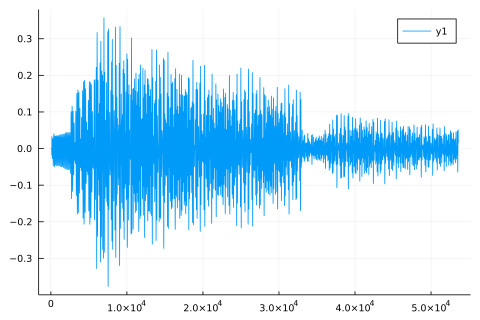

In [27]:
p_1 = plot(
    1:div(size(x[1],1),10),
    (x[1][1:div(size(x[1],1),10),1]),
    dpi=80,
)

In [71]:
Random.seed!(1)
k12 = rand(0:1000)/1000.0
println(k12)
k13 = rand(0:1000)/1000.0
println(k13)
k14 = rand(0:1000)/1000.0
println(k14)
k23 = rand(0:1000)/1000.0
println(k23)
k24 = rand(0:1000)/1000.0
println(k24)
k34 = rand(0:1000)/1000.0
println(k34)

0.357
0.106
0.956
0.326
0.416
0.958


In [72]:
## integration
U = zeros(div(num_iter, modstep), dim)

qYtail = [1];

Random.seed!(1234)

time_array = [t0, t0, dt]

# noise terms
nt = zeros(num_iter, 2);



In [73]:
if isQW
    @time SIEiters(CoupledQW, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
else
    if n_lasers == 3
        @time SIEiters(CoupledQD, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
    else
        @time SIEiters(CoupledQD4, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
    end
        
end

 33.438260 seconds (494.14 M allocations: 28.165 GiB, 15.55% gc time)


1

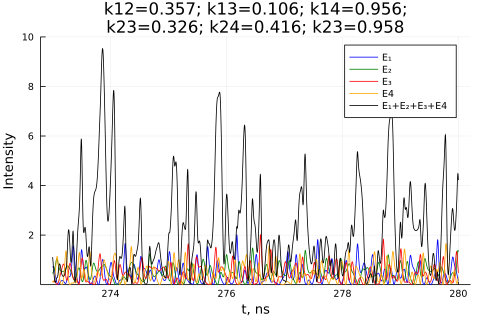

In [74]:
pl_st_t = endtime - 10 * τdelay;
pl_en_t = endtime;
n = 3000; # number of timepoints for plot
pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
pl_en_in = div(floor(Int, pl_en_t / dt), modstep);
pl_step = max(1, div(floor(Int, (pl_en_in - pl_st_in) / n), modstep));
forplot1 = (U[pl_st_in:pl_step:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[1]] .^ 2);
ts = collect(range(pl_st_t, stop = pl_en_t, length = length(forplot1))).*tphys./10^(-9);
p1 = plot(
    ts,
    forplot1,
    ylims = (0.95 *  minimum(forplot1), 1.05 * maximum(forplot1)),
    xlabel = "t",
    ylabel = "Intensity",
    label = "E₁",
    title = string("k12=", k12, "; k13=", k13, "; k14=", k14, ";\nk23=", k23, "; k24=", k24, "; k23=",k34),
    linecolor = :blue,
    dpi=80,
)
forplot2 = (U[pl_st_in:pl_step:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[2]] .^ 2);
plot!(
    ts,
    forplot2,
    ylims = (0.95 *  minimum(forplot2), 1.05 * maximum(forplot2)),
    xlabel = "t",
    label = "E₂",
    linecolor = :green,
    dpi=80,
)
forplot3 = (U[pl_st_in:pl_step:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[3]] .^ 2);
plot!(
    ts,
    forplot3,
    ylims = (0.95 *  minimum(forplot3), 1.05 * maximum(forplot3)),
    xlabel = "t",
    label = "E₃",
    linecolor = :red,
    dpi=80,
)
if n_lasers == 3 
    
    forplot4 =
    abs2.(
        U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
        U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
        U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]],
    )
    plot!(
        ts,
        forplot4,
        ylims = (0, 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4])))),
        xlabel = "t, ns",
        label = "E₁+E₂+E₃",
        linecolor = :black,
        dpi=80,
    )
else
    forplot4 = (U[pl_st_in:pl_step:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[4]] .^ 2);
    plot!(
        ts,
        forplot4,
        ylims = (0.95 *  minimum(forplot4), 1.05 * maximum(forplot4)),
        xlabel = "t",
        label = "E4",
        linecolor = :orange,
        dpi=80,
    )
    forplot5 =
    abs2.(
        U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
        U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
        U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]] .+
        U[pl_st_in:pl_step:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[4]],
    )
    plot!(
        ts,
        forplot5,
        ylims = (0.95 *  minimum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5]))), 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5])))),
        xlabel = "t, ns",
        label = "E₁+E₂+E₃+E4",
        linecolor = :black,
        dpi=80,
    )

end

In [69]:
for rand_i=1:100
    Random.seed!(1234)

    
    qY1 = zeros(dim, hist_len);
    qY2 = zeros(dim, hist_len);
    for i = 1:hist_len
        qY1[:, i] = randn(dim) .^ 2
        qY1[:, i] = qY1[:, i] ./ maximum(qY1[:, i]) / 1000
        qY2[:, i] = randn(dim) .^ 2
        qY2[:, i] = qY2[:, i] ./ maximum(qY2[:, i]) / 1000
    end
    
    Random.seed!(rand_i)
    
    
    k12 = rand(0:1000)/1000.0
    k13 = rand(0:1000)/1000.0
    k14 = rand(0:1000)/1000.0
    k23 = rand(0:1000)/1000.0
    k24 = rand(0:1000)/1000.0
    k34 = rand(0:1000)/1000.0

    ## integration
    U = zeros(div(num_iter, modstep), dim)

    qYtail = [1];

    time_array = [t0, t0, dt]

    # noise terms
    nt = zeros(num_iter, 2)

    if isQW
        @time SIEiters(CoupledQW, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
    else
        if n_lasers == 3
            @time SIEiters(CoupledQD, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
        else
            @time SIEiters(CoupledQD4, num_iter, modstep, time_array, p0, nt, qY1, qY2, qYtail, U, tauind)
        end
    end

    pl_st_t = endtime - 10 * τdelay;
    pl_en_t = endtime;
    n = 3000; # number of timepoints for plot
    pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
    pl_en_in = div(floor(Int, pl_en_t / dt), modstep);
    pl_step = max(1, div(floor(Int, (pl_en_in - pl_st_in) / n), modstep));
    forplot1 = (U[pl_st_in:pl_step:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[1]] .^ 2);
    ts = collect(range(pl_st_t, stop = pl_en_t, length = length(forplot1))).*tphys./10^(-9);
    p1 = plot(
        ts,
        forplot1,
        ylims = (0.95 *  minimum(forplot1), 1.05 * maximum(forplot1)),
        xlabel = "t",
        ylabel = "Intensity",
        label = "E₁",
        title = string("k12=", k12, "; k13=", k13, "; k14=", k14, ";\nk23=", k23, "; k24=", k24, "; k23=",k34),
        linecolor = :blue,
        dpi=80,
    )
    if true
        forplot2 = (U[pl_st_in:pl_step:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[2]] .^ 2);
        plot!(
            ts,
            forplot2,
            ylims = (0.95 *  minimum(forplot2), 1.05 * maximum(forplot2)),
            xlabel = "t",
            label = "E₂",
            linecolor = :green,
            dpi=80,
        )
        forplot3 = (U[pl_st_in:pl_step:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[3]] .^ 2);
        plot!(
            ts,
            forplot3,
            ylims = (0.95 *  minimum(forplot3), 1.05 * maximum(forplot3)),
            xlabel = "t",
            label = "E₃",
            linecolor = :red,
            dpi=80,
        )
        if n_lasers == 3 

            forplot4 =
            abs2.(
                U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]],
            )
            plot!(
                ts,
                forplot4,
                ylims = (0, 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4])))),
                xlabel = "t, ns",
                label = "E₁+E₂+E₃",
                linecolor = :black,
                dpi=80,
            )
        else
            forplot4 = (U[pl_st_in:pl_step:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_step:pl_en_in, Imind[4]] .^ 2);
            plot!(
                ts,
                forplot4,
                ylims = (0.95 *  minimum(forplot4), 1.05 * maximum(forplot4)),
                xlabel = "t",
                label = "E4",
                linecolor = :orange,
                dpi=80,
            )
            forplot5 =
            abs2.(
                U[pl_st_in:pl_step:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_step:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_step:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[3]] .+
                U[pl_st_in:pl_step:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_step:pl_en_in, Imind[4]],
            )
            plot!(
                ts,
                forplot5,
                ylims = (0.95 *  minimum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5]))), 1.05 * maximum(collect(Iterators.flatten([forplot1, forplot2, forplot3, forplot4,forplot5])))),
                xlabel = "t, ns",
                label = "E₁+E₂+E₃+E4",
                linecolor = :black,
                dpi=80,
            )
        end

        pl_st_t = endtime - 800 * τdelay;
        pl_en_t = endtime;
        pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
        pl_en_in = div(floor(Int, pl_en_t / dt), modstep);

        # optical spectrum
        optfreq =
            fftshift(fftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys))) ./ 10^9;

        optspec1 =
            10 *
            log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[1]] + im * U[pl_st_in:pl_en_in, Imind[1]]))));

        optspec2 =
            10 *
            log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[2]] + im * U[pl_st_in:pl_en_in, Imind[2]]))));

        optspec3 =
            10 *
            log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[3]] + im * U[pl_st_in:pl_en_in, Imind[3]]))));

        optspec4 =
            10 *
            log10.(abs2.(fftshift(fft(
                U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
            ))));
        optspec5 = optspec4
        optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4])));
        if n_lasers == 3

            optspec1 = optspec1 .- optspec0dB;
            optspec2 = optspec2 .- optspec0dB;
            optspec3 = optspec3 .- optspec0dB;
            optspec4 = optspec4 .- optspec0dB;
        else
            optspec4 =
            10 *
            log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[4]] + im * U[pl_st_in:pl_en_in, Imind[4]]))));

            optspec5 =
                10 *
                log10.(abs2.(fftshift(fft(
                    U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                    U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                    U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
                    U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
                ))));
            optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4, optspec5])));
            optspec1 = optspec1 .- optspec0dB;
            optspec2 = optspec2 .- optspec0dB;
            optspec3 = optspec3 .- optspec0dB;
            optspec4 = optspec4 .- optspec0dB;
            optspec5 = optspec5 .- optspec0dB;
        end
        # rf spectrum
        rffreq = rfftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys)) ./ 10^9;
        rfspec1 =
            10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_en_in, Imind[1]] .^ 2)));
        rfspec2 =
            10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_en_in, Imind[2]] .^ 2)));
        rfspec3 =
            10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_en_in, Imind[3]] .^ 2)));
        rfspec4 =
            10 *
            log10.(abs2.(rfft(abs2.(
                U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
            ))));

        rfspec5 = rfspec4

        rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4])));
        if n_lasers == 3
            rfspec1 = rfspec1 .- optspec0dB;
            rfspec2 = rfspec2 .- optspec0dB;
            rfspec3 = rfspec3 .- optspec0dB;
            rfspec4 = rfspec4 .- optspec0dB;
        else
            rfspec4 =
                10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_en_in, Imind[4]] .^ 2)));
            rfspec5 =
                10 *
                log10.(abs2.(rfft(abs2.(
                    U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
                    U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
                    U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
                    U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
                ))));


            rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4, rfspec5])));
            rfspec1 = rfspec1 .- optspec0dB;
            rfspec2 = rfspec2 .- optspec0dB;
            rfspec3 = rfspec3 .- optspec0dB;
            rfspec4 = rfspec4 .- optspec0dB;
            rfspec5 = rfspec5 .- optspec0dB;
        end
        p2 = plot(
            optfreq,
            optspec1,
            xlabel = "Optical Frequency, GHz",
            xlims = (-20, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :blue,
            dpi=80,
        )
        plot!(
            optfreq,
            optspec2,
            xlabel = "Optical Frequency, GHz",
            xlims = (-20, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :green,
            dpi=80,
        )
        plot!(
            optfreq,
            optspec3,
            xlabel = "Optical Frequency, GHz",
            xlims = (-20, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :red,
            dpi=80,
        )
        if n_lasers == 3
            plot!(
                optfreq,
                optspec4,
                xlabel = "Optical Frequency, GHz",
                xlims = (-10, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :black,
                ylims = (-100, 5),
                dpi=80,
            )
        else

            plot!(
                optfreq,
                optspec4,
                xlabel = "Optical Frequency, GHz",
                xlims = (-20, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :orange,
                dpi=80,
            )
            plot!(
                optfreq,
                optspec5,
                xlabel = "Optical Frequency, GHz",
                xlims = (-10, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :black,
                ylims = (-100, 5),
                dpi=80,
            )
        end
        p3 = plot(
            rffreq,
            rfspec1,
            xlabel = "RF Frequency, GHz",
            xlims = (0, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :blue,
            dpi=80,
        )
        plot!(
            rffreq,
            rfspec2,
            xlabel = "RF Frequency, GHz",
            xlims = (0, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :green,
            dpi=80,
        )
        plot!(
            rffreq,
            rfspec3,
            xlabel = "RF Frequency, GHz",
            xlims = (0, 20),
            ylabel = "Power density, dB",
            legend = false,
            linecolor = :red,
            dpi=80,
        )
        if n_lasers == 3
            plot!(
                rffreq,
                rfspec4,
                xlabel = "RF Frequency, GHz",
                xlims = (0, 20),
                ylims = (-100, 5),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :black,
                dpi=80,
            )
        else
            plot!(
                rffreq,
                rfspec4,
                xlabel = "RF Frequency, GHz",
                xlims = (0, 20),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :orange,
                dpi=80,
            )
            plot!(
                rffreq,
                rfspec5,
                xlabel = "RF Frequency, GHz",
                xlims = (0, 20),
                ylims = (-100, 5),
                ylabel = "Power density, dB",
                legend = false,
                linecolor = :black,
                dpi=80,
            )
        end
    end
    p1 = plot(p1, p2, p3, layout = (3, 1), size = (800, 900),dpi=200)

    #display(pall)

    # save figure
    if isQW
        #savefig(pall,string("QW_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,".png"))
        savefig(p1,string("QW_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,".png"))
    else
        #savefig(pall,string("QD_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,".png"))
        savefig(p1,string("QD_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"_k12=", k12, "_k13=", k13, "_k14=", k14, "_k23=", k23, "_k24=", k24, "_k23=",k34,"_i=", rand_i,".png"))
    end
end

 33.822545 seconds (494.14 M allocations: 28.165 GiB, 14.10% gc time)
 36.099053 seconds (494.14 M allocations: 28.165 GiB, 14.46% gc time)
 33.704488 seconds (494.14 M allocations: 28.165 GiB, 14.75% gc time)
 37.703751 seconds (494.14 M allocations: 28.165 GiB, 13.56% gc time)
 35.151828 seconds (494.14 M allocations: 28.165 GiB, 14.51% gc time)
 38.742410 seconds (494.14 M allocations: 28.165 GiB, 13.46% gc time)
 35.678760 seconds (494.14 M allocations: 28.165 GiB, 14.40% gc time)
 35.040249 seconds (494.14 M allocations: 28.165 GiB, 14.81% gc time)
 37.293661 seconds (494.14 M allocations: 28.165 GiB, 13.49% gc time)
 35.180568 seconds (494.14 M allocations: 28.165 GiB, 14.07% gc time)
 36.833365 seconds (494.14 M allocations: 28.165 GiB, 13.72% gc time)
 35.266965 seconds (494.14 M allocations: 28.165 GiB, 14.10% gc time)
 35.211146 seconds (494.14 M allocations: 28.165 GiB, 14.57% gc time)
 36.925428 seconds (494.14 M allocations: 28.165 GiB, 13.91% gc time)
 35.477290 seconds (

### Результаты доступны по ссылке:
#### https://drive.google.com/drive/folders/1-wfE3Z2vqJF6lj1Ku_jiQb7T8cZbP6xH?usp=sharing

In [ ]:
pl_st_t = endtime - 800 * τdelay;
pl_en_t = endtime;
pl_st_in = max(1, div(floor(Int, pl_st_t / dt), modstep));
pl_en_in = div(floor(Int, pl_en_t / dt), modstep);

# optical spectrum
optfreq =
    fftshift(fftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys))) ./ 10^9;

optspec1 =
    10 *
    log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[1]] + im * U[pl_st_in:pl_en_in, Imind[1]]))));

optspec2 =
    10 *
    log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[2]] + im * U[pl_st_in:pl_en_in, Imind[2]]))));

optspec3 =
    10 *
    log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[3]] + im * U[pl_st_in:pl_en_in, Imind[3]]))));

optspec4 =
    10 *
    log10.(abs2.(fftshift(fft(
        U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
        U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
        U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
    ))));
optspec5 = optspec4
optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4])));
if n_lasers == 3

    optspec1 = optspec1 .- optspec0dB;
    optspec2 = optspec2 .- optspec0dB;
    optspec3 = optspec3 .- optspec0dB;
    optspec4 = optspec4 .- optspec0dB;
else
    optspec4 =
    10 *
    log10.(abs2.(fftshift(fft(U[pl_st_in:pl_en_in, Reind[4]] + im * U[pl_st_in:pl_en_in, Imind[4]]))));

    optspec5 =
        10 *
        log10.(abs2.(fftshift(fft(
            U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
            U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
            U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
            U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
        ))));
    optspec0dB = maximum(collect(Iterators.flatten([optspec1, optspec2, optspec3, optspec4, optspec5])));
    optspec1 = optspec1 .- optspec0dB;
    optspec2 = optspec2 .- optspec0dB;
    optspec3 = optspec3 .- optspec0dB;
    optspec4 = optspec4 .- optspec0dB;
    optspec5 = optspec5 .- optspec0dB;
end
# rf spectrum
rffreq = rfftfreq(length(U[pl_st_in:pl_en_in, Reind[1]]), 1 / (dt * modstep * tphys)) ./ 10^9;
rfspec1 =
    10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[1]] .^ 2 + U[pl_st_in:pl_en_in, Imind[1]] .^ 2)));
rfspec2 =
    10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[2]] .^ 2 + U[pl_st_in:pl_en_in, Imind[2]] .^ 2)));
rfspec3 =
    10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[3]] .^ 2 + U[pl_st_in:pl_en_in, Imind[3]] .^ 2)));
rfspec4 =
    10 *
    log10.(abs2.(rfft(abs2.(
        U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
        U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
        U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]],
    ))));

rfspec5 = rfspec4

rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4])));
if n_lasers == 3
    rfspec1 = rfspec1 .- optspec0dB;
    rfspec2 = rfspec2 .- optspec0dB;
    rfspec3 = rfspec3 .- optspec0dB;
    rfspec4 = rfspec4 .- optspec0dB;
else
    rfspec4 =
        10 * log10.(abs2.(rfft(U[pl_st_in:pl_en_in, Reind[4]] .^ 2 + U[pl_st_in:pl_en_in, Imind[4]] .^ 2)));
    rfspec5 =
        10 *
        log10.(abs2.(rfft(abs2.(
            U[pl_st_in:pl_en_in, Reind[1]] .+ im .* U[pl_st_in:pl_en_in, Imind[1]] .+
            U[pl_st_in:pl_en_in, Reind[2]] .+ im .* U[pl_st_in:pl_en_in, Imind[2]] .+
            U[pl_st_in:pl_en_in, Reind[3]] .+ im .* U[pl_st_in:pl_en_in, Imind[3]] .+
            U[pl_st_in:pl_en_in, Reind[4]] .+ im .* U[pl_st_in:pl_en_in, Imind[4]],
        ))));


    rfspec0dB =  maximum(collect(Iterators.flatten([rfspec1, rfspec2, rfspec3, rfspec4, rfspec5])));
    rfspec1 = rfspec1 .- optspec0dB;
    rfspec2 = rfspec2 .- optspec0dB;
    rfspec3 = rfspec3 .- optspec0dB;
    rfspec4 = rfspec4 .- optspec0dB;
    rfspec5 = rfspec5 .- optspec0dB;
end
p2 = plot(
    optfreq,
    optspec1,
    xlabel = "Optical Frequency, GHz",
    xlims = (-20, 20),
    ylabel = "Power density, dB",
    legend = false,
    linecolor = :blue,
    dpi=80,
)
plot!(
    optfreq,
    optspec2,
    xlabel = "Optical Frequency, GHz",
    xlims = (-20, 20),
    ylabel = "Power density, dB",
    legend = false,
    linecolor = :green,
    dpi=80,
)
plot!(
    optfreq,
    optspec3,
    xlabel = "Optical Frequency, GHz",
    xlims = (-20, 20),
    ylabel = "Power density, dB",
    legend = false,
    linecolor = :red,
    dpi=80,
)
if n_lasers == 3
    plot!(
        optfreq,
        optspec4,
        xlabel = "Optical Frequency, GHz",
        xlims = (-10, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :black,
        ylims = (-100, 5),
        dpi=80,
    )
else
    
    plot!(
        optfreq,
        optspec4,
        xlabel = "Optical Frequency, GHz",
        xlims = (-20, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :orange,
        dpi=80,
    )
    plot!(
        optfreq,
        optspec5,
        xlabel = "Optical Frequency, GHz",
        xlims = (-10, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :black,
        ylims = (-100, 5),
        dpi=80,
    )
end
p3 = plot(
    rffreq,
    rfspec1,
    xlabel = "RF Frequency, GHz",
    xlims = (0, 20),
    ylabel = "Power density, dB",
    legend = false,
    linecolor = :blue,
    dpi=80,
)
plot!(
    rffreq,
    rfspec2,
    xlabel = "RF Frequency, GHz",
    xlims = (0, 20),
    ylabel = "Power density, dB",
    legend = false,
    linecolor = :green,
    dpi=80,
)
plot!(
    rffreq,
    rfspec3,
    xlabel = "RF Frequency, GHz",
    xlims = (0, 20),
    ylabel = "Power density, dB",
    legend = false,
    linecolor = :red,
    dpi=80,
)
if n_lasers == 3
    plot!(
        rffreq,
        rfspec4,
        xlabel = "RF Frequency, GHz",
        xlims = (0, 20),
        ylims = (-100, 5),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :black,
        dpi=80,
    )
else
    plot!(
        rffreq,
        rfspec4,
        xlabel = "RF Frequency, GHz",
        xlims = (0, 20),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :orange,
        dpi=80,
    )
    plot!(
        rffreq,
        rfspec5,
        xlabel = "RF Frequency, GHz",
        xlims = (0, 20),
        ylims = (-100, 5),
        ylabel = "Power density, dB",
        legend = false,
        linecolor = :black,
        dpi=80,
    )
end
pall = plot(p1, p2, p3, layout = (3, 1), size = (400, 600), dpi = 200)

display(pall)

# save figure
if isQW
    savefig(pall,string("QW_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"k12=", k12, "; k13=", k13, "; k14=", k14, ";\nk23=", k23, "; k24=", k24, "; k23=",k34,".png"))
else
    savefig(pall,string("QD_nJ_", nJthr,"_kap_",κ,"_gam_",γ,"k12=", k12, "; k13=", k13, "; k14=", k14, ";\nk23=", k23, "; k24=", k24, "; k23=",k34,".png"))
end